cuda
PyTorch score 0.8754796071172072
Inference score 0.21898339674863623


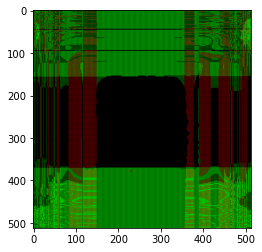

In [1]:
import os
import torch
import numpy as np
import setup.dataset as dataset
import setup.ResUNet as ResUNet
import setup.classifier as classifier
from torch.utils.data import SubsetRandomSampler
from PIL import Image
import cv2
import inference.engine as engine
import inference.inference as inference
import torch.nn.functional as F
import tensorrt as trt
import matplotlib.pyplot as plt

np.random.seed(0)
torch.manual_seed(0)

DATASET_PATH = 'dataset'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

def sampler_indices(length):
    indices = list(range(length))
    np.random.shuffle(indices)
    split = int(np.floor(0.1 * length))
    test_indices = indices[:split]
    return test_indices

weed_dataset = dataset.WeedDataset(DATASET_PATH, random_transform=False)

test_indices = sampler_indices(len(weed_dataset))

FILTER_LIST = [16,32,64,128,256]

model = ResUNet.ResUNet(FILTER_LIST).to(device)
path = 'outputs/ResUNet.pt'

classifier = classifier.WeedClassifier(model, device)

if str(device) == 'cpu':
    classifier.model.load_state_dict(torch.load(path, map_location='cpu'))
else:
    classifier.model.load_state_dict(torch.load(path))

image_index = test_indices[12]
sample = weed_dataset[image_index]

rgb, mask, output, score = classifier.predict(sample)

print('PyTorch score', score)

engine = engine.load_engine('outputs/ResUNet.plan')
input = sample['image'].view((-1, 4, 512, 512))

DATA_TYPE = trt.float16

inference_output = inference.do_inference(engine, input, data_type=DATA_TYPE)

print('Inference score', classifier.miou(inference_output, sample['mask']))


# inference_output = F.softmax(inference_output, dim=1, dtype=DATA_TYPE)
inference_output = torch.argmax(inference_output, dim=1)

inference_output = classifier.decode_segmap(inference_output)
# now inference_output treat same as output
inference_output = Image.fromarray((inference_output * 255).astype(np.uint8))
plt.imshow(inference_output)

